## <center> École Polytechnique de Montréal <br> Département Génie Informatique et Génie Logiciel <br>  INF8460 – Traitement automatique de la langue naturelle <br> </center>
## <center> TP1 INF8460 <br>  Automne 2021 </center>

## 1. DESCRIPTION
Dans ce TP, l’idée est d’effectuer de la recherche de passages de texte dans un corpus à partir d’une question en langue naturelle. Les questions et passages sont en anglais.

Voici un exemple : <br>
__Entrée : Question :__ What causes precipitation to fall?  

__Solution - Trouver un passage qui contient la réponse à la question :__ In meteorology, precipitation is any product of the condensation of atmospheric water vapor that falls under <mark> __gravity__ </mark>. The main forms of precipitation include drizzle, rain, sleet, snow, graupel and hail... Precipitation forms as smaller droplets coalesce via collision with other rain drops or ice crystals within a cloud. Short, intense periods of rain in scattered locations are called “showers”. 

Ici la réponse est en gras dans le texte.

## 2. LIBRARIES PERMISES
- Jupyter notebook
- NLTK
- Numpy 
- Pandas
- Sklearn
- Pour toute autre librairie, demandez à votre chargé de laboratoire


## 3. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)

## 4. DESCRIPTION DES DONNEES

Dans ce projet, vous utiliserez le jeu de données dans le répertoire _data_. Il est décomposé en données d’entrainement (train), de validation (dev) et de test (test). <br>

Nous ne mettrons à votre disposition que les données d’entrainement et de validation. Les données de test ne contiennent pas le paragraphe de réponse et doivent être complétées avec les résultats de votre système.
Nous vous fournissons un ensemble de données qui comprend un corpus (_corpus.csv_) qui contient tous les passages et leurs identificateurs (ID) et un jeu de données qui associe une question, un passage, et une réponse qui est directement extraite du passage. Notez que certains passages contiennent des balises HTML et qu’il vous faudra procéder à un prétraitement de ces passages pour les enlever. <br>
Ce jeu de données est composé de trois sous-ensembles : 
- _Train_ : ensemble d’entraînement de la forme <QuestionID, QuestionText, PassageID, Réponse>. Le but est donc d’entrainer votre modèle à retrouver le passage qui contient la réponse à la question.
- _Validation_ : De la même forme que le Train, il vous permet de valider votre entraînement et de tester les performances de certains modules.  
- _Test_ : Un ensemble secret qui est utilisé pour évaluer votre système complet. Il est de la forme <QuestionID, Question>. Votre système doit trouver dans le corpus __corpus.csv__ le ou les passages les plus pertinents.

Notez qu’il est possible de répondre aux requis du TP sans utiliser la réponse à la question. C’est à vous de choisir si vous utilisez la réponse ou non. 

## 5. ETAPES DU TP 
A partir du notebook _inf8460_A21_TP1_ qui est distribué, vous devez réaliser les étapes suivantes. (Noter que les cellules dans le squelette sont là à titre informatif - il est fort probable que vous rajoutiez des sections au fur et à mesure de votre TP).

Ci-dessous définir la constante _PATH_ qui doit être utilisée par votre code pour accéder aux fichiers. Il est attendu que pour la correction, le chargé de lab n'ait qu'à changer la valeur de _PATH_ pour le répertoire où se trouver les fichiers de datasets.

In [4]:
PATH = "data/"
N = 200

### 5.1. Pré-traitement (12 points)
Les passages et questions de votre ensemble de données doivent d’abord être représentés et indexés pour ensuite pouvoir effectuer une recherche de passage pour répondre à une question. On vous demande donc d’implémenter une étape de pré-traitement des données.
1) (_6 points_) Complétez les fonctions retournant les informations suivantes (une fonction par information, chaque fonction prenant en argument le corpus (passages, questions) composé d'une liste de phrases segmentées en jetons/tokens) :
    1. Le nombre total de jetons (mots non distincts)
    2. Le nombre total de mots distincts (les types qui constituent le vocabulaire)
    3. Les N mots les plus fréquents du vocabulaire (N est un paramètre avec une valeur par défaut de 10) ainsi que leur fréquence
    4. Le ratio jeton/type
    5. Le nombre total de lemmes distincts
    6. Le nombre total de racines (stems) distinctes

In [132]:
import pandas
import nltk
import string
import re
import math 
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
nltk.download('punkt')
nltk.download('wordnet')
nltk.download("stopwords")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\simon\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [22]:
data_corpus = pandas.read_csv(PATH + "corpus.csv")
data_questions = pandas.read_csv(PATH + "train_ids.csv")

In [23]:
data_corpus

,id,paragraph
0,0,The Normans (Norman: Nourmands; French: Norman...
1,1,"The Norman dynasty had a major political, cult..."
2,2,"The English name ""Normans"" comes from the Fren..."
3,3,"In the course of the 10th century, the initial..."
4,4,"Before Rollo's arrival, its populations did no..."
...,...,...
83322,83322,<P> Reevis ' first movie job was as a stunt ri...
83323,83323,<P> `` Up on Cripple Creek '' is the fifth son...
83324,83324,<P> The fifth season of the American televisio...
83325,83325,<P> Footballer Danny Blanchflower turned down ...


In [7]:
corpus_example = [["banana", "bananas", "banana", "wolves", "wolf"], ["hello", "you", "are", "my", "friend"]]

In [8]:
def count_tokens(corpus):
    counter = 0
    for element in corpus :
        counter += len(element)
    return counter

def count_types(corpus):
    set_of_words = set()
    for sentence in corpus :
        for word in sentence : 
            set_of_words.add(word)
    return len(set_of_words)

def count_most_frequent_tokens(corpus, n):
    tokens = defaultdict(lambda: 0)
    for text in corpus:
        for word in text:
            tokens[word] += 1
    
    tokens = sorted(tokens.items(), key=lambda x: x[1], reverse=True)
    return tokens[0:n]

def ratio_token_type(corpus):
    return count_tokens(corpus) / count_types(corpus)

def count_lemmas(corpus):
    lemmzer = WordNetLemmatizer()
    tokens = set()
    for text in corpus:
        for word in text:
            tokens.add(lemmzer.lemmatize(word))
    return len(tokens)

def count_stems(corpus):
    stemmer = PorterStemmer()
    tokens = set()
    for text in corpus:
        for word in text:
            tokens.add(stemmer.stem(word))
    return len(tokens)

2. (_1 point_) Ecrivez une fonction explore_corpus() qui fait appel à toutes les fonctions en 1) et imprime leur résultat.


In [9]:
def explore_corpus(corpus):
    print("Le nombre total de jetons: ", count_tokens(corpus))
    print("Le nombre total de mots distincts: ", count_types(corpus))
    print("Les N mots les plus fréquents du vocabulaires: ", count_most_frequent_tokens(corpus, N))
    print("Le ratio jeton/type: ", ratio_token_type(corpus))
    print("Le nombre total de racines (stems) distinctes: ", count_stems(corpus))
    print("Le nombre total de lemmes distincts: ", count_lemmas(corpus))

In [10]:
explore_corpus(corpus_example)

Le nombre total de jetons:  10
Le nombre total de mots distincts:  9
Les N mots les plus fréquents du vocabulaires:  [('banana', 2), ('bananas', 1), ('wolves', 1), ('wolf', 1), ('hello', 1), ('you', 1), ('are', 1), ('my', 1), ('friend', 1)]
Le ratio jeton/type:  1.1111111111111112
Le nombre total de racines (stems) distinctes:  8
Le nombre total de lemmes distincts:  7


3. (_5 points_) Pour la suite du TP, vous devez effectuer le pré-traitement du corpus (questions, passages) en convertissant le texte en minuscules, en segmentant le texte, en supprimant les mots outils et en lemmatisant le texte. Chaque opération doit avoir sa fonction python si elle n’est pas déjà implantée dans la question 1) précédente.

In [11]:
def clean_html(text) :
    #Remove html's tag from a string 'text'
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', text)
    return cleantext

def remove_punctuation(text) :
    return re.sub(r'[^\w\s]','',text)

def tokenize_text(text):
    return nltk.word_tokenize(text.lower().strip())

def remove_small_words(tokens, min_length) :
    for word in tokens :
        if len(word) < min_length :
            tokens.remove(word)
    return tokens

def remove_stopwords(tokens):
    return [word for word in tokens if not word in stopwords.words('english')]

def lemmatize_tokens(tokens) :
    lemmzer = WordNetLemmatizer()
    return [lemmzer.lemmatize(word) for word in tokens]

def text_preprocessor(text) :
    text_clean = remove_punctuation(clean_html(text))
    tokens = tokenize_text(text_clean)
    clean_tokens = remove_small_words(lemmatize_tokens(remove_stopwords(tokens)),4)
    return " ".join(clean_tokens)

def preprocessing(df, column) :
    #From an input dataframe and a given column which contains a string, add a new column with the text clean and tokenized
    data = df[column].apply(text_preprocessor)
    df["processed"] = data
    return df

### 5.2. Représentation de questions et de passages (14 points)

1. (_10 points_) En utilisant sklearn et à partir de votre corpus pré-traité, vous devez implanter un modèle M1 qui est de représenter chaque passage et question avec votre vocabulaire, en utilisant un modèle sac de mots des n-grammes (n=1) qu’ils contiennent et en pondérant ces éléments avec TF-IDF. Notez que les questions doivent aussi être inclues dans la construction du vocabulaire.

In [111]:
index_to_cut = 1000

In [112]:
processed_corpus = preprocessing(data_corpus[0:index_to_cut], "paragraph")
processed_questions = preprocessing(data_questions[0:index_to_cut], "question")

<ipython-input-11-83076435b702>:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["processed"] = data


In [144]:
def tf_idf_M1(processed_questions, processed_corpus, N) :
    vectorizer = TfidfVectorizer(smooth_idf=False, max_features = N)
    vectorizer.fit(pandas.concat([processed_questions["processed"], processed_corpus["processed"]], ignore_index = True))
    tfidf_corpus = vectorizer.transform(processed_corpus["processed"]) 
    print("Vocabulary :" + "\n\n", vectorizer.get_feature_names())
    return tfidf_corpus, vectorizer

In [145]:
tfidf_M1, vectorizer_M1 = tf_idf_M1(processed_questions, processed_corpus, N)

Vocabulary :

 ['algorithm', 'along', 'also', 'although', 'american', 'among', 'another', 'area', 'around', 'article', 'based', 'became', 'body', 'building', 'california', 'called', 'case', 'cell', 'center', 'central', 'century', 'change', 'channel', 'chicago', 'china', 'chinese', 'church', 'city', 'civil', 'class', 'college', 'common', 'community', 'company', 'complexity', 'construction', 'could', 'country', 'county', 'court', 'ctenophore', 'developed', 'development', 'different', 'drug', 'dynasty', 'early', 'east', 'economic', 'education', 'effect', 'engine', 'established', 'european', 'even', 'example', 'field', 'first', 'flow', 'following', 'form', 'found', 'four', 'france', 'free', 'french', 'fresno', 'general', 'given', 'government', 'great', 'group', 'growth', 'harvard', 'held', 'high', 'higher', 'home', 'however', 'huguenot', 'human', 'immune', 'important', 'include', 'including', 'income', 'increase', 'individual', 'inequality', 'ipcc', 'jacksonville', 'john', 'justice', 'know

2. (_4 points_) Expérimentez maintenant avec un modèle n-gramme (n=1,2) mélangeant les unigrammes et les bigrammes et pondéré avec TF-IDF.

In [146]:
def tf_idf_M2(processed_questions, processed_corpus, N) :
    vectorizer = TfidfVectorizer(smooth_idf=False, max_features = N, ngram_range=(1,2))
    vectorizer.fit(pandas.concat([processed_questions["processed"], processed_corpus["processed"]], ignore_index = True))
    tfidf_corpus = vectorizer.transform(processed_corpus["processed"]) 
    print("Vocabulary :" + "\n\n", vectorizer.get_feature_names())
    return tfidf_corpus, vectorizer

In [147]:
tfidf_M2, vectorizer_M2 = tf_idf_M2(processed_questions, processed_corpus, N)

Vocabulary :

 ['algorithm', 'along', 'also', 'although', 'american', 'among', 'another', 'area', 'around', 'article', 'based', 'became', 'body', 'building', 'california', 'called', 'case', 'cell', 'center', 'central', 'century', 'change', 'channel', 'chicago', 'china', 'chinese', 'church', 'city', 'civil', 'class', 'college', 'common', 'community', 'company', 'complexity', 'construction', 'could', 'country', 'county', 'court', 'court justice', 'ctenophore', 'developed', 'development', 'different', 'drug', 'dynasty', 'early', 'east', 'economic', 'education', 'effect', 'engine', 'established', 'european', 'european union', 'even', 'example', 'field', 'first', 'following', 'form', 'found', 'four', 'france', 'french', 'fresno', 'general', 'given', 'government', 'great', 'group', 'growth', 'harvard', 'held', 'high', 'higher', 'home', 'however', 'huguenot', 'human', 'immune', 'immune system', 'important', 'include', 'including', 'income', 'increase', 'inequality', 'ipcc', 'jacksonville', 'j

Pour M1 et M2, assurez-vous de réutiliser la même fonction avec comme paramètre les n-grammes à considérer.

### 5.3. Ordonnancement des passages (10 points)
Maintenant que vous avez une représentation de vos passages et questions, il faut être capable de déterminer quel passage sera le plus pertinent pour la question posée. Il vous faut donc retrouver un top-N (N=1,5,10 … ) de passages utiles pour répondre à la question. Ces passages devront être ordonnés du plus pertinent au moins pertinent. Idéalement le passage à la position 1 sera celui qui contient la réponse à la question.
<br>
<br>
Vous devez écrire des fonctions pour évaluer la similarité entre la représentation de la question et celle de chaque passage et retourner les N passage les plus similaires où N est un paramètre. 
1. (_5 points_) En utilisant la distance euclidienne


In [148]:
top_N = 30

In [189]:
def process_question(question, vectorizer) :
    preprocessed_question = [text_preprocessor(question)]
    return vectorizer.transform(preprocessed_question)

In [150]:
tfidf_question_M1 = process_question("Philo of Byzantium ____ surmised that air converted to fire", vectorizer_M1)
tfidf_question_M2 = process_question("Philo of Byzantium ____ surmised that air converted to fire", vectorizer_M2)

In [209]:
def question_answer(tfidf_question, tfidf_corpus, data_corpus, distance, top_N) :
    distances = distance(tfidf_question, tfidf_corpus)[0]
    data_corpus_copy = data_corpus.copy()
    data_corpus_copy["distance"] = distances
    sorted_data_corpus = data_corpus_copy.sort_values(by='distance')
    return sorted_data_corpus[0:top_N]

In [210]:
#Answers returned by the first model with euclidean distance
question_answer(tfidf_question, tfidf_M1, data_corpus[0:index_to_cut], euclidean_distances, top_N).index

Int64Index([608, 696, 336, 752, 478, 643, 943, 487, 876, 999,  65, 705,  55,
            503, 778, 792, 339, 653,  80,  81, 392, 912, 120, 412, 721, 691,
             41, 899, 427, 428],
           dtype='int64')

In [211]:
#Answers returned by the second model with euclidean distance
question_answer(tfidf_question_M1, tfidf_M2, data_corpus[0:index_to_cut], euclidean_distances, top_N).index

Int64Index([696, 437, 598, 913, 365, 427, 560, 264, 738, 412, 935,  41, 263,
             86, 503, 778, 691, 261,  81, 258, 943,  55, 760, 603,  65, 899,
            478, 643, 428, 991],
           dtype='int64')

2. (_5 points_) En utilisant la distance cosinus

In [212]:
#Answers returned by the first model with cosine distance
question_answer(tfidf_question_M1, tfidf_M1, data_corpus[0:index_to_cut], cosine_distances, top_N).index

Int64Index([  0, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669,
            670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682,
            683, 684, 657, 685],
           dtype='int64')

In [213]:
#Answers returned by the second model with cosine distance
question_answer(tfidf_question_M2, tfidf_M2, data_corpus[0:index_to_cut], cosine_distances, top_N)["paragraph"]

0      The Normans (Norman: Nourmands; French: Norman...
658    During Reconstruction and the Gilded Age, Jack...
659    On May 3, 1901, downtown Jacksonville was rava...
660    In the 1910s, New York–based filmmakers were a...
661    Jacksonville, like most large cities in the Un...
662    Much of the city's tax base dissipated, leadin...
663    In the mid-1960s, corruption scandals began to...
664    When a consolidation referendum was held in 19...
665    According to the United States Census Bureau, ...
666    The tallest building in Downtown Jacksonville'...
667    Like much of the south Atlantic region of the ...
668    Mean monthly temperatures range from around 53...
669    Jacksonville has suffered less damage from hur...
670    Jacksonville is the most populous city in Flor...
671    As of 2010[update], there were 366,273 househo...
672    A study by the World Institute for Development...
673    According to PolitiFact the top 400 richest Am...
674    Neoclassical economics v

### 5.4. Évaluation (15 points)
En utilisant votre ensemble de validation : <br>
1. (_5 points_) Vous devez calculer la précision top-N (N=1,5,10, 50) de votre modèle M1 et M2 avec la distance euclidienne et cosinus et les afficher. 


In [190]:
def compute_precision(data_questions, data_corpus, vectorizer, distance, tfidf, top_N) :
    count_good_answers = 0
    for i in range(len(data_questions)) :
        raw_question = data_questions["question"][i]
        tfidf_question = process_question(raw_question, vectorizer)
        paragraph_id_answer = data_questions["paragraph_id"][i]
        indexes_top_N = question_answer(tfidf_question, tfidf, data_corpus, distance, top_N)["id"]
        if paragraph_id_answer in(indexes_top_N) :
            count_good_answers += 1
    return round(count_good_answers/len(data_questions)*100,2)

In [214]:
precision_euclidean_M1 = compute_precision(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M1, euclidean_distances, tfidf_M1, top_N)

In [215]:
precision_euclidean_M2 = compute_precision(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M2, euclidean_distances, tfidf_M2, top_N)

In [216]:
precision_cosine_M1 = compute_precision(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M1, cosine_distances, tfidf_M1, top_N)

In [217]:
precision_cosine_M2 = compute_precision(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M2, cosine_distances, tfidf_M2, top_N)

In [218]:
print("For the first model and the euclidean distance, the precision is about", precision_euclidean_M1, "%")
print("For the second model and the euclidean distance, the precision is about", precision_euclidean_M2, "%")
print("For the first model and the cosine distance, the precision is about", precision_cosine_M1, "%")
print("For the second model and the cosine distance, the precision is about", precision_cosine_M2, "%")

For the first model and the euclidean distance, the precision is about 1.5 %
For the second model and the euclidean distance, the precision is about 1.5 %
For the first model and the cosine distance, the precision is about 1.4 %
For the second model and the cosine distance, the precision is about 1.4 %


2. (_5 points_) Pour chacun de ces modèles, générez une courbe de performance faisant varier le N (N=1, 5, 10, 50)

In [219]:
tops_N = [1, 5, 10, 50]

In [220]:
def generate_plot(data_questions, data_corpus, vectorizer, distance, tfidf, tops_N, model_name, distance_name) :
    precisions = []
    for current_N in tops_N :
        precision = compute_precision(data_questions, data_corpus, vectorizer, distance, tfidf, current_N)
        precisions.append(precision)
    plt.plot(tops_N, precisions)
    plt.title("Performance du modèle " + model_name + " et pour la distance" + distance_name)
    plt.xlabel("N")
    plt.ylabel("Precision")

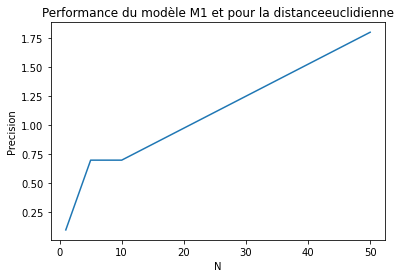

In [221]:
generate_plot(data_questions[0:index_to_cut], data_corpus[0:index_to_cut], vectorizer_M1, euclidean_distances, tfidf_M1, tops_N, "M1", "euclidienne")

3. (_5 points_) A cette étape, vous devez produire un fichier _passage_submission_M1.csv_ et _passage_submission_M2.csv_ qui contient pour toutes les questions de l’ensemble de test le top-N des passages retournés par votre modèle M1 et M2 pour y répondre. C’est à vous de déterminer si vous utiliserez la distance euclidienne ou cosinus basé sur vos résultats d’évaluation sur l’ensemble de validation en 1) et 2). Le fichier doit respecter le format suivant pour chaque top_N(N=1,5,10,50) :  <QuestionID, PassageID1 ;… ;PassageIDN>. Le format est démontré dans _sample_passage_submission.csv_.

### 5.5. Le plus (24 points)

1. (_21 points_) Vous devez proposer un modèle M3 différent (basé sur l’apprentissage machine par exemple) afin de déterminer un score de pertinence d’un passage pour une question donnée et ordonner les passages. 
    - Faites une petite recherche sur l’état de l’art en consultant https://nlp.stanford.edu/IR-book/information-retrieval-book.html
    - Vous êtes libres de proposer une autre métrique de poids, ou une autre façon d’ordonner les passages (exemple : méthodes de type _learning to rank_) et de partir de votre corpus initial ou de votre ordonnancement en M1/M2 (choisissez le meilleur) et de réordonnancer les passages obtenus par votre premier modèle.
    - Expliquez votre modèle et son intérêt dans votre notebook. Le nombre de points obtenus dépendra de l’effort mis dans cette partie.

### Idée 1 :

Reprendre le meilleur des modèles entre M1 et M2 et les matrices de distances associées. Pour chacune de ces matrices, on code 0 : le passage envoyé est le bon, 1 le passage renvoyé est mauvais. Le modèle renvoie ensuite la réponse qui lui parait la plus probable avec un modèle type régression logistique (ou autre).

### Idée 2 :

On change seulement la métrique de poids.

2. (_2  point_) Vous devez ensuite afficher l’évaluation de votre modèle M3 tel que décrit dans la section 5.4 Evaluation en utilisant les mêmes fonctions. Notamment, vous devez comparer les performances de vos modèles M1, M2 et M3 sur l’ensemble de validation avec une courbe de performance faisant varier le N (N=1, 5, 10, …)

3. (_1 point_) En utilisant votre modèle M3, vous devez produire un fichier passage_submission_M3.csv qui contient pour toutes les questions de l’ensemble de test le top-N des passages retournés par votre système pour y répondre. Le fichier doit respecter le format suivant pour chaque top_N (N=1,5,10,50) :  <QuestionID, PassageID1…PassageIDN>. _Le format est démontré dans sample_passage_submission.csv_

## LIVRABLES
Vous devez remettre sur Moodle:
1. _Le code_ : Un Jupyter notebook en Python qui contient le code implanté avec les librairies permises. Le code doit être exécutable sans erreur et accompagné des commentaires appropriés dans le notebook de manière à expliquer les différentes fonctions et étapes dans votre projet. Nous nous réservons le droit de demander une démonstration ou la preuve que vous avez effectué vous-mêmes les expériences décrites. _Attention, en aucun cas votre code ne doit avoir été copié d’une quelconque source_. Les critères de qualité tels que la lisibilité du code et des commentaires sont importants. Tout votre code et vos résultats doivent être exécutables et reproductibles ; 
2. Un fichier _requirements.txt_ doit indiquer toutes les librairies / données nécessaires ;
3. Un lien _GoogleDrive_ ou similaire vers les modèles nécessaires pour exécuter votre notebook si approprié ;
4. Les fichiers de soumission de données de test _passage_submission_M1.csv_ et _passage_submission_M2.csv_
5. Un document _contributions.txt_ : Décrivez brièvement la contribution de chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. En particulier, tous les membres du projet devraient participer à la conception du TP et participer activement à la réflexion et à l’implémentation du code.

## EVALUATION 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code
2. Performance correcte des modèles
3. Organisation du notebook
4. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
5. Commentaires clairs et informatifs

## CODE D’HONNEUR
- Règle 1:  Le plagiat de code est bien évidemment interdit.
- Règle 2: Vous êtes libres de discuter des idées et des détails de mise en œuvre avec d'autres équipes. Cependant, vous ne pouvez en aucun cas consulter le code d'une autre équipe INF8460, ou incorporer leur code dans votre TP.
- Règle 3:  Vous ne pouvez pas partager votre code publiquement (par exemple, dans un dépôt GitHub public) tant que le cours n'est pas fini.
